In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import pandas as pd

from src.data import load_cora
from src.features.cora_feature import split
from src.models import train_cora
from src.models.mlp_graph import MLPGraph
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

In [2]:
# reproducibility
random_seed = 123
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

## Load the Dataset

In [3]:
edge_df=pd.read_csv("../data/raw/large_twitch_edges.csv")
feature_df=pd.read_csv("../data/raw/large_twitch_features.csv")

In [4]:
feature_df_time = feature_df.copy()
feature_df_time[["created_at_year", "created_at_month", "created_at_day"]] = feature_df_time["created_at"].str.split('-', expand = True).astype(int)
feature_df_time[["updated_at_year", "updated_at_month", "updated_at_day"]] = feature_df_time["updated_at"].str.split('-', expand = True).astype(int)

In [5]:
def encode_data():
    OHE_features = []
    other_features = ["views", "mature", "life_time", "dead_account", "affiliate"]
    all_features = OHE_features + other_features

    OHE = OneHotEncoder()
    CT = ColumnTransformer([("one hot encoding", OHE, OHE_features)], remainder = "passthrough")

    feature_matrix = CT.fit_transform(feature_df_time[all_features])

    return feature_matrix

def construct_graph(feature_matrix):
    if type(feature_matrix) != np.ndarray:
        feature_matrix = feature_matrix.todense()
    node_features = torch.tensor(feature_matrix).to(torch.float32)

    LE = LabelEncoder()
    label_vector = LE.fit_transform(feature_df_time["language"])
    node_labels = torch.tensor(label_vector).long()
    
    edges_list = edge_df.values.tolist()
    edge_index1 = torch.tensor(edges_list, dtype = torch.long).T
    edge_index2 = torch.zeros(edge_index1.shape, dtype = torch.long)
    edge_index2[0,:] = edge_index1[1,:]
    edge_index2[1,:] = edge_index1[0,:]
    edge_index = torch.cat((edge_index1, edge_index2), axis = 1)
    g = Data(x = node_features, y = node_labels, edge_index = edge_index)

    return g

In [6]:
data_encoded = encode_data()
graph = construct_graph(data_encoded)

In [7]:
num_inputs = graph.x.shape[0]
num_outputs = len(torch.unique(graph.y))

### Split the data into train, validation, and test

In [8]:
split = RandomNodeSplit(split = "train_rest", num_splits = 1, num_val = 0.2, num_test = 0.1)
graph = split(graph)
print(graph, "\n")
print("training samples", torch.sum(graph.train_mask).item())
print("validation samples", torch.sum(graph.val_mask).item())
print("test samples", torch.sum(graph.test_mask).item())

Data(x=[168114, 5], edge_index=[2, 13595114], y=[168114], train_mask=[168114], val_mask=[168114], test_mask=[168114]) 

training samples 117680
validation samples 33623
test samples 16811


## Training & Result


Pre-training prepare
	Run on: CPU
	Optimizer with 0.001 leraning rate and 0.0005 weight_dacay

Begin to train:
	Epoch: 1, Training Loss: 3.1780147552490234, Validation Score: 0.004461232107132673, Test Score: 0.005294152535498142
	Epoch: 10, Training Loss: 2.8825767040252686, Validation Score: 0.1431163251399994, Test Score: 0.14710606634616852
	Epoch: 20, Training Loss: 2.4114491939544678, Validation Score: 0.49564287066459656, Test Score: 0.49782881140708923
	Epoch: 30, Training Loss: 1.8755725622177124, Validation Score: 0.7090681791305542, Test Score: 0.7140562534332275
	Epoch: 40, Training Loss: 1.452052354812622, Validation Score: 0.806947648525238, Test Score: 0.8098863959312439
	Epoch: 50, Training Loss: 1.1806873083114624, Validation Score: 0.8656574487686157, Test Score: 0.8666349649429321
	Epoch: 60, Training Loss: 0.9947856664657593, Validation Score: 0.8839782476425171, Test Score: 0.8831717371940613
	Epoch: 70, Training Loss: 0.8522012829780579, Validation Score: 0.88591

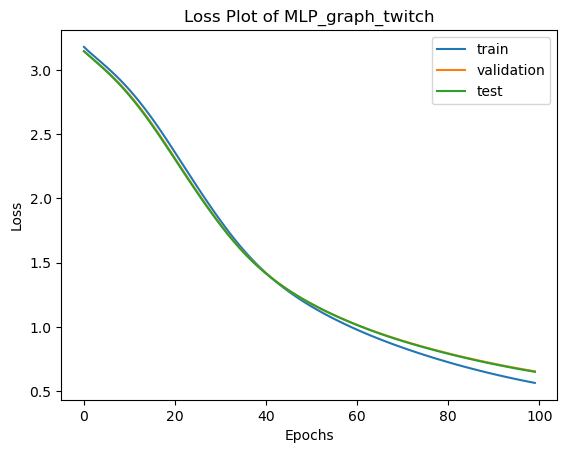

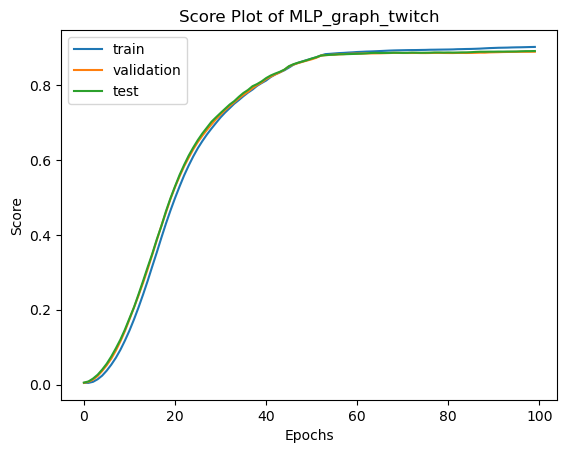

In [9]:
device = None
model = MLPGraph(num_inputs=num_inputs, num_outputs=num_outputs, seed=random_seed, sparse=True)
criterion = torch.nn.CrossEntropyLoss()
train_cora.start_train(model, graph, criterion, model_name="MLP_graph_twitch", device=device)